# Menace

Welcome to the Menace Jupyter Notebook interface! This notebook contains examples of how to run the pipeline on a dataset, load the resulting output dataframes and perform analysis and visualisation using seaborn.  **If you are using Menace as part of any published scientific work, please cite  "".**

In [1]:
import menace

In [2]:
import menace.lib.Community

In [3]:
from menace.__main__ import *

In [4]:
#config = menace.get_config()
args = get_parser().parse_args(['full'])
config = read_config(args)
config = compile_config(args,config)

## Load Abundance and Relative C periods

In [100]:
import pandas as pd
import numpy as np
from os.path import join

In [101]:
c = pd.DataFrame.from_csv(join(config['output_path'],"Collect","C.csv"),  sep=';')
ab = pd.DataFrame.from_csv(join(config['output_path'],"Collect","CellAbundance.csv"),  sep=';')
ab = ab.ix[:,np.argsort(ab.columns)]
c = c.ix[:,np.argsort(c.columns)]

In [102]:
# make data frames with rows sorted according to mean abundance across species
s=ab.transpose().mean().sort_values(ascending=False).index.values
ab2=ab.ix[list(s),:]
c2=c.ix[list(s),:]

In [103]:
# numpy arrays needed for some correlation stuff (fix NaN values not ideal)
data=ab2.fillna(0).as_matrix()
data2=c2.fillna(0).as_matrix()

## Visualization

In [52]:
%matplotlib inline
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
sns.set_context("paper")

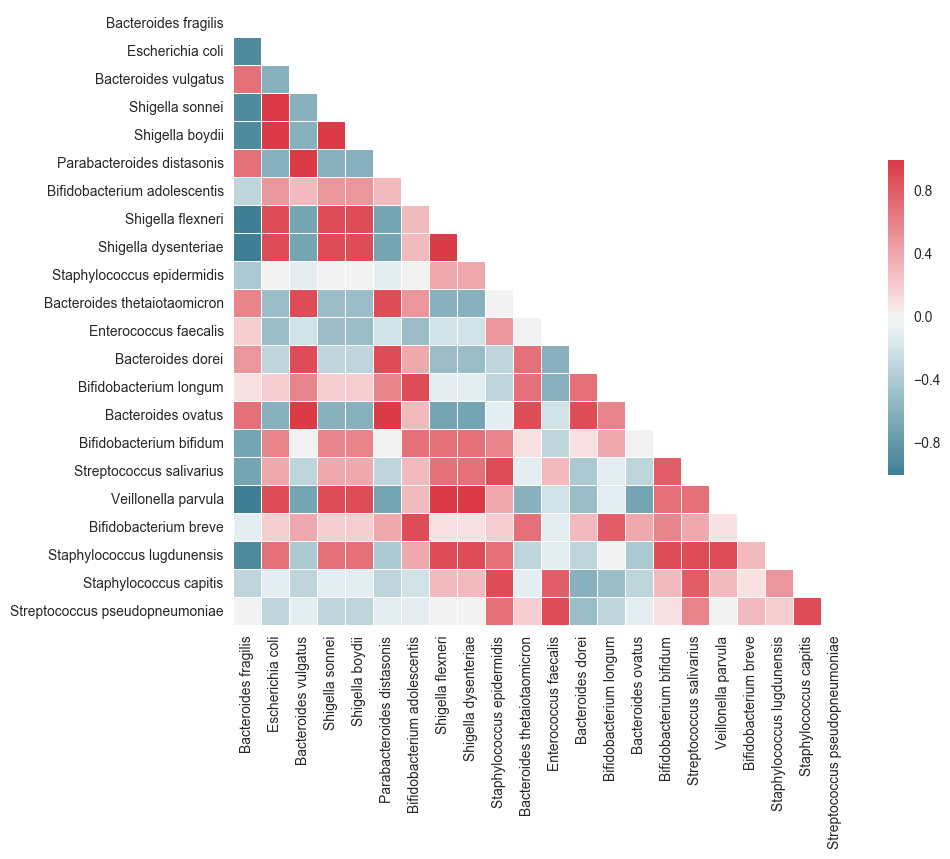

In [53]:
# correlation of abundance
sns.set(style="white")
corr=ab2.transpose().corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')

f.subplots_adjust(left=0.2,bottom=0.2)

f.savefig('Figures/Species_Ab_Correlation.pdf')

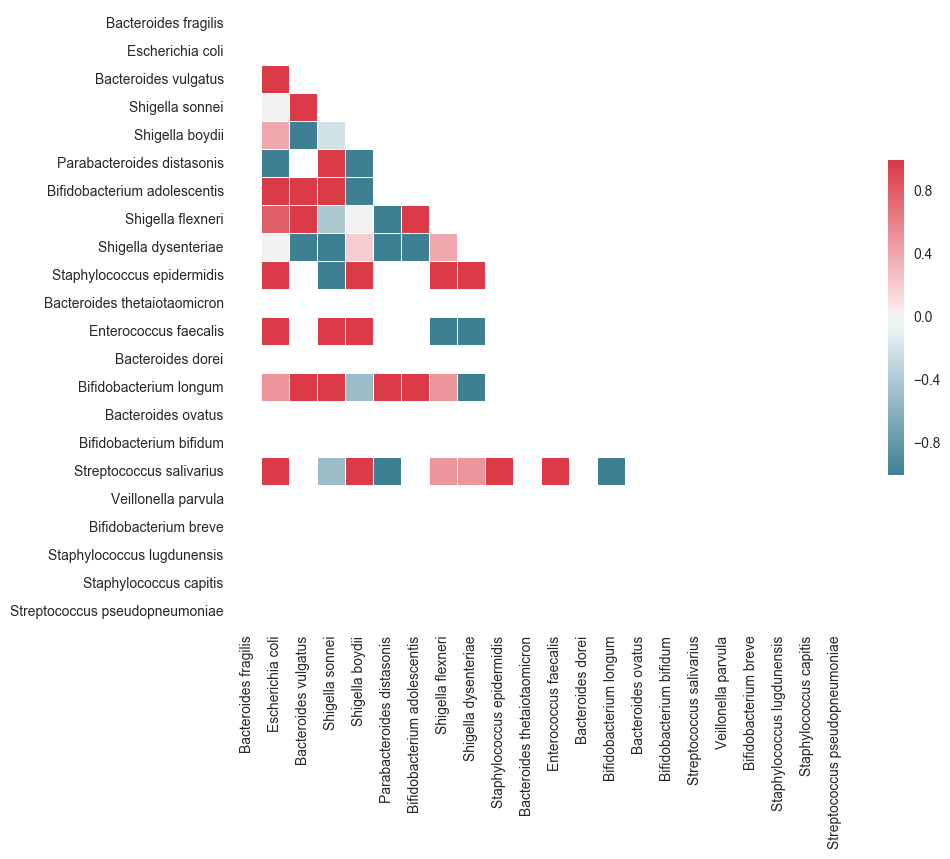

In [54]:
# correlation of C periods
sns.set(style="white")
corr=c2.transpose().corr('spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('')

f.subplots_adjust(left=0.2,bottom=0.2)

f.savefig('Figures/Species_C_Correlation.pdf')

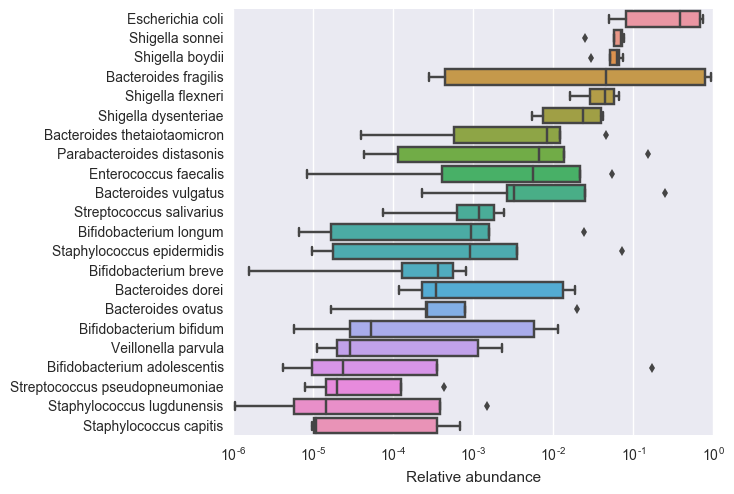

In [113]:
# ab boxplots per species
ab_data=ab2.where(ab2>10**(-6))
sns.set(style="darkgrid")

order=ab_data.transpose().median().sort_values(ascending=False).index.values

ax=sns.boxplot(ab_data.transpose(),orient="h",order=order)
ax.set_xlabel('Relative abundance')
ax.set_ylabel('')
ax.set(xscale="log")

fig = ax.get_figure()
fig.subplots_adjust(left=0.3)
fig.savefig('Figures/Species_Ab_boxplot.pdf')

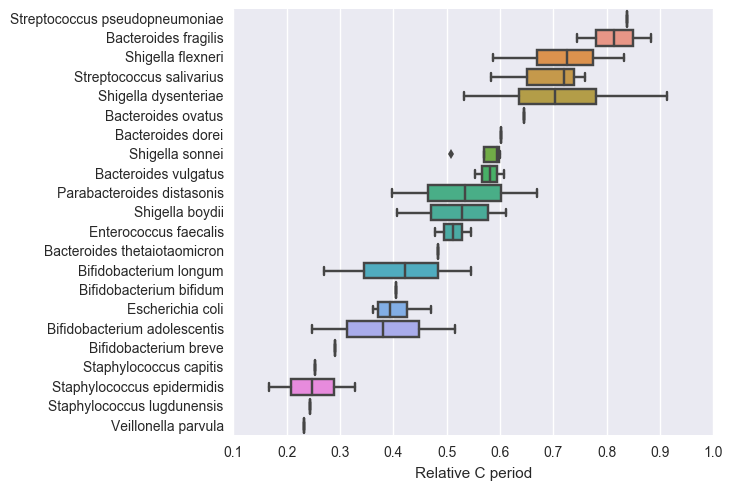

In [62]:
# C periods boxplot per species
sns.set(style="darkgrid")
#ax.axvline(1, 0, 2, linewidth=2, c='r')
ax=sns.boxplot(c.transpose(),orient="h",order=c.transpose().median().sort_values(ascending=False).index.values)
ax.set_xlabel('Relative C period')
ax.set_ylabel('')

fig = ax.get_figure()
fig.subplots_adjust(left=0.3)
fig.savefig('Figures/Species_C_periods_boxplot.pdf', bbox_inches='tight', pad_inches=0)

# Clustering

In [104]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [105]:
n_components=2
n_clusters=3

In [106]:
# PCA example to reduce dimensionality
pca = PCA(n_components=n_components)
pca.fit(data.transpose())
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print(pca.explained_variance_ratio_) 

[ 0.82757933  0.16787745]


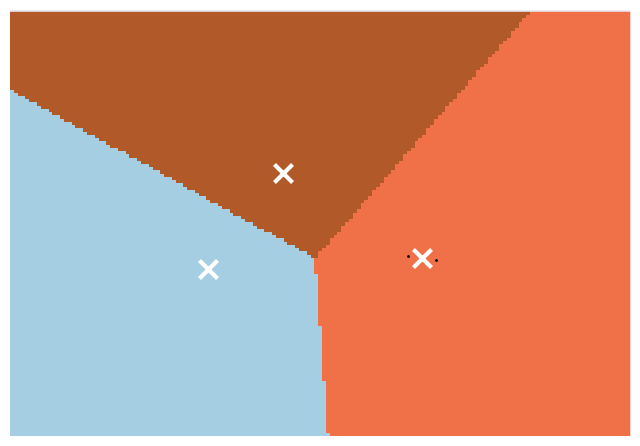

In [107]:
# basic clustering based on 2 components, number of clusters must be checked manually
reduced_data = PCA(n_components=n_components).fit_transform(data.transpose())
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=4)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
#plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
#          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [108]:
# make sorted dataframes according to above clustering
cluster_ind=kmeans.fit_predict(reduced_data)
cluster_sort=np.argsort(cluster_ind)
cluster_ind_sort=np.sort(cluster_ind)
line_pos=(np.where(np.diff(cluster_ind_sort)==1)+np.array(1))[0]
abs2=ab2.ix[:,list(cluster_sort)]
cs2=c2.ix[:,list(cluster_sort)]

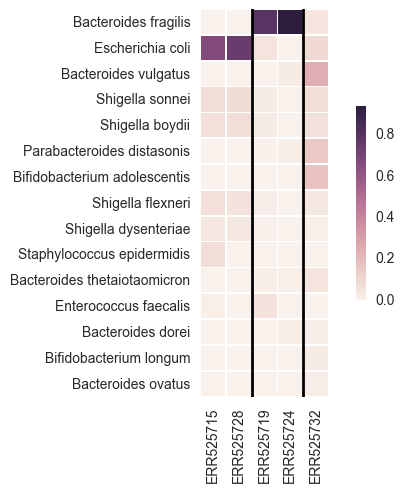

In [109]:
# abundance heatmap
# sort according to kmeans cluster
#s=ab.index.values[list(ind)]
#abs2=ab.reindex(list(s))

#abs2sort=abs2.ix[:, abs2.max().sort_values(ascending=False).index]

f, ax = plt.subplots(figsize=(7, 5))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(abs2.ix[:15],linewidths=.5,square=True,ax=ax, cbar_kws={"shrink": .5})

ax.set_xlabel('')
ax.set_ylabel('')
cluster_ind_sort

for pos in line_pos:
    ax.axvline(pos, 0, 2, linewidth=2, c='k')

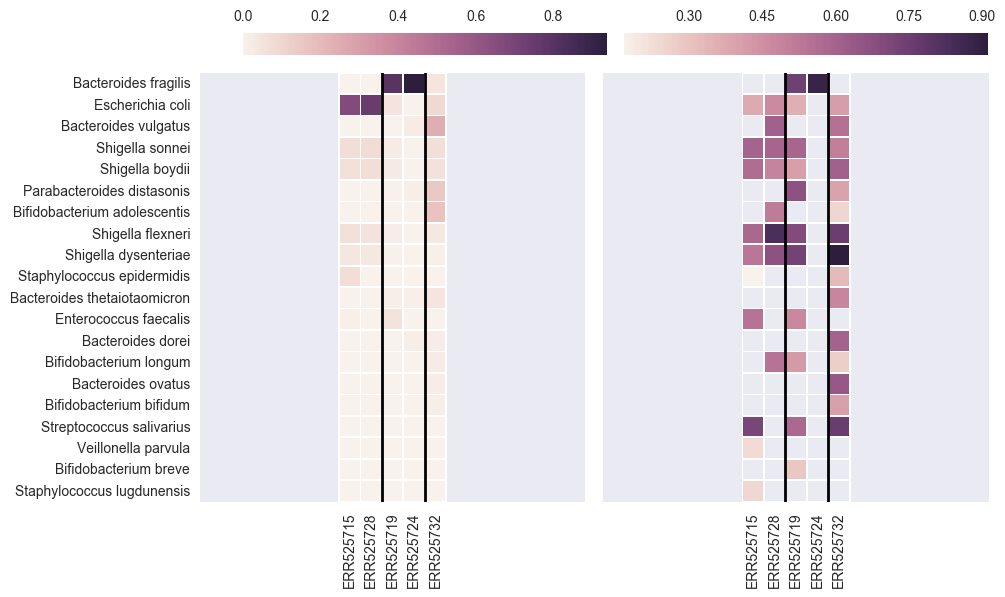

In [110]:
# combined abundance and c period plot
sns.set(style="dark")
n=20 # species displayed

fig,axn = plt.subplots(1, 2, sharey=True)

h=[abs2.ix[:n,:],cs2.ix[:n,:]]

cmap=[sns.cubehelix_palette(18,light=.95,as_cmap=True),
      sns.cubehelix_palette(18,light=.95,as_cmap=True)]

for i, ax in enumerate(axn.flat):
    cbar_ax = fig.add_axes([0.315+i*.477, 1, .455, .04])
    
    sns.heatmap(h[i], ax=ax,cbar=True,cbar_kws={'orientation':'horizontal'},
                cbar_ax=cbar_ax,linewidths=.5,square=True,cmap=cmap[i])#,
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    cbar_ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    cbar_ax.invert_yaxis()
    cbar_ax.xaxis.tick_top()

    for pos in line_pos:
        ax.axvline(pos, 0, 2, linewidth=2, c='k')

# manual layout (fix)
fig.tight_layout(rect=[0, 0, 1.27, 1])

fig.savefig('Figures/heatmap_ab_ptr2.pdf', bbox_inches='tight', pad_inches=0)

## Run a Menace Docker Container

In [1]:
import docker

## Perform tests on artificial metagenomic communities

In [1]:
import docker

In [2]:
#cli = docker.from_env()

In [3]:
#cli = docker.Client(base_url='unix://var/run/docker.sock')
img = 'sysbio-chalmers/menace'
#envs = docker.utils.parse_env_file(join(td,'env_centos'))
envs = ""

In [4]:
acc=['NC_000913.3','NC_007779.1','NC_002655.2','NC_009614.1','NC_017218.1']
growth_param=[[.2, .5, .3, 100],[.2, .5, .3, 100],[.2, .5, .3,100],[0.0001, .8, .2, 100],[.1, .7, .2,100]]
sel=[[0,4]]
td=u'/Users/hedani/Documents/GitRepos/PTRloc/tt_MenaceNB'
accessions=[acc[s] for s in sel[0]]
community_params=[growth_param[s] for s in sel[0]]

In [11]:
c=Comm.Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2',img,envs,'hedani@chalmers.se')
c.build_index()
tot_reads=np.linspace(10**5,10**5,1)
for nr in tot_reads:
    c.sample(nr)
c.write_reads()
c.run_pipeline()
c.collect()

TypeError: create_mount_run() takes exactly 5 arguments (4 given)

# Other

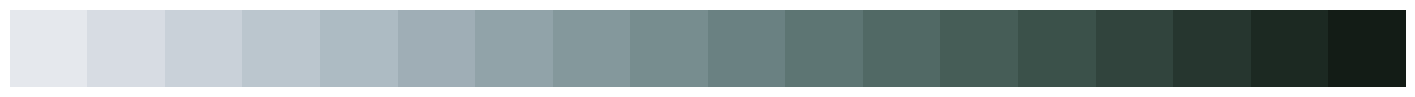

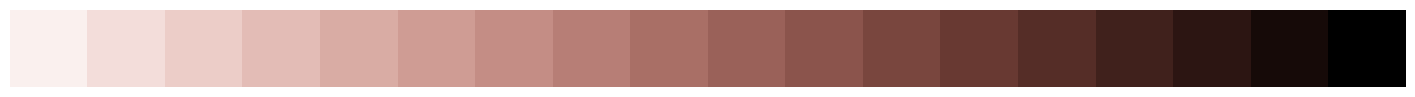

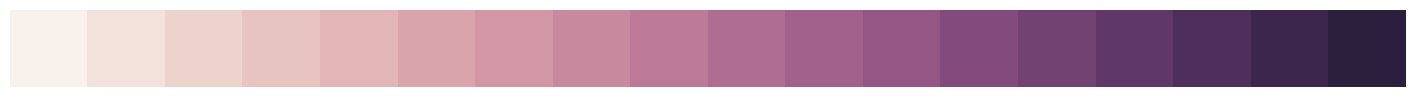

In [225]:
# color palettes
sns.palplot(sns.cubehelix_palette(18, start=2, rot=0.3, dark=.1, light=.91,hue=.3))
sns.palplot(sns.cubehelix_palette(18, start=1, rot=0, dark=0, light=.95))
sns.palplot(sns.cubehelix_palette(18,light=.95))